# TfidfVectorizer: how it works

In this notebook, we get acquainted with the [`TfidfVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from scikit learn.

In [1]:
%run notebook_utils.py

In [4]:
import sklearn 
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib

# set big font in plots
SMALL_SIZE = 20
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

## TfidfVectorizer: example of creation

Here is an example of creation using the most interesting arguments for our purpose.

In [6]:
# example of vectorizer creation
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
  analyzer='char',        # character-based model
  ngram_range=(3,5),      # variable width ngrams 
  use_idf=False,          # don't ponderate tf by inverse document frequency
  sublinear_tf=False,     # don't apply log to frequences (tf: n VS tf: l)
  max_features=100,       # keep only the N most frequent ngrams 
  norm='l2'               # normalize the document-term matrix during transform
                          # (important for variable length sentences)
)

## TfidfVectorizer: sublinear_tf and norm arguments

Here, we try to better understand how the `sublinear_tf` and `norm` arguments work.


__Normalisation__ takes place after all tokens have been counter. The count vector is then _normalised_, i.e. each cell is divided by the norm $n$ of the vector. $n$ is computed using either the  _l1-norm_ or the _l2-norm_. 

The __l1 norm__ is basically summing the vector values:

$$ L1 = \sum_{i=1}^{n} |x_i| $$

The __l2 norm__ corresponds to the usual definition of the mathematical norm:

$$ L2 =  \sqrt{\sum_{i=1}^{n} x_i^2} $$


The __sublinear_tf__ happens _after normalisation_. If set, it will apply the log to each cell: $ x = 1 + log(x) $. This is often used in text processing, on the assumption that a word that appears twice as often as another is not twice as important.

In [7]:
test_sentence = "lulu " # ngrams: lu=2 ul=1 u =1

# create all possible combinations of the two arguments
options = [dict(sublinear_tf=stf, norm=n) for n in [None, 'l1', 'l2'] for stf in [False, True]]
# create one vectorizer for each combination
vecs = [(opt, TfidfVectorizer(analyzer='char', ngram_range=(2,2), use_idf=False, **opt)) for opt in options]

# use the test sentence with all combination
for opt, v in vecs:
    print("\nusing ", opt, "\n")
    res = v.fit_transform([test_sentence])
    print("\n".join(["  %s => %s" % t for t in zip(v.get_feature_names(), res.toarray()[0])]))


using  {'sublinear_tf': False, 'norm': None} 

  lu => 2.0
  u  => 1.0
  ul => 1.0

using  {'sublinear_tf': True, 'norm': None} 

  lu => 1.6931471805599454
  u  => 1.0
  ul => 1.0

using  {'sublinear_tf': False, 'norm': 'l1'} 

  lu => 0.5
  u  => 0.25
  ul => 0.25

using  {'sublinear_tf': True, 'norm': 'l1'} 

  lu => 0.45845645943177243
  u  => 0.27077177028411376
  ul => 0.27077177028411376

using  {'sublinear_tf': False, 'norm': 'l2'} 

  lu => 0.8164965809277261
  u  => 0.4082482904638631
  ul => 0.4082482904638631

using  {'sublinear_tf': True, 'norm': 'l2'} 

  lu => 0.7674945674619879
  u  => 0.4532946552278861
  ul => 0.4532946552278861


## Using TFIdfVectorizer for prediction

Now that we understand a bit better how the vectorizer works, it is time to test it as a feature extractor to predict languages. Here, we just use a basic identifier based on a naive bayes approach.

The `NaiveIdentifier` uses the `TFIdfVectorizer` under the hood (it creates one vectorizer per language to be precise) with the following default options:

```python
{
    analyzer='char',  
    ngram_range=(3, 5), 
    max_features=3000,
    sublinear_tf=True, 
    use_idf=True, 
    norm='l2'
}
```

To override those default, just pass new values to the constructor.


__important__: once again, we don't preprocess/sanitize the data, so the results might not be incredible.

_Note_: use `NaiveIdentifier??` in a cell to inspect the source code.

In [22]:
%cd ..
from langid import NaiveIdentifier
%cd -

/Users/Lin/git/SwigSpot/language-detection
/Users/Lin/git/SwigSpot/language-detection/notebooks


In [24]:
# see the script included at the beginning of the notebook
X_train, X_test, y_train, y_test = load_split_data()

### IDF

Here, we use the vectorizer with default arguments, `use_idf=True` and we varie the kind of normalisation.
As we will see, with normalisation we have slightly worse results that with l2-normalisation. What is also interesting is that for Swiss German, no normalisation favorises the recall, while l2-norm favorises the precision.

#### IDF - No normalisation

             precision    recall  f1-score   support

         de     0.9809    0.9145    0.9465      1462
         fr     0.9966    0.9980    0.9973      1468
         en     0.9858    0.9948    0.9903      1538
         it     0.9953    0.9960    0.9956      1482
         sg     0.9145    0.9666    0.9398      1438

avg / total     0.9750    0.9743    0.9743      7388



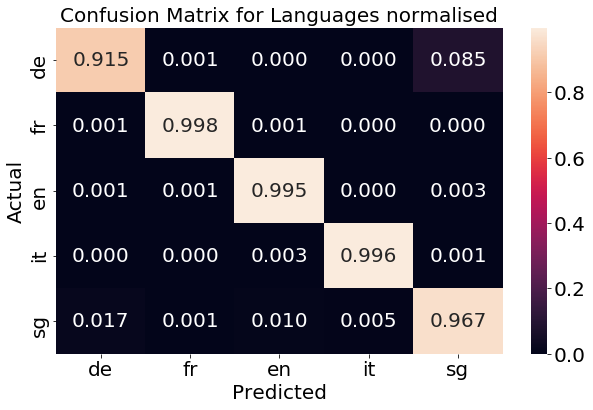

total samples    10706
total errors       171 (1.60%)
---------------------------------
languages detected
    de      106
    fr       18
    en       18
    it       29
    sg    10535


In [26]:
%%time
nid = NaiveIdentifier(norm=None).fit(X_train, y_train)
y_predicted = nid.predict(X_test)
print_results(y_test, y_predicted)
plot_confusion_matrix(y_test, y_predicted, normalised=True)
test_recall_with_sms(nid)

#### IDF - L2 normalisation

             precision    recall  f1-score   support

         de     0.9693    0.9932    0.9811      1462
         fr     0.9939    0.9973    0.9956      1468
         en     0.9871    0.9974    0.9922      1538
         it     0.9940    0.9987    0.9963      1482
         sg     0.9934    0.9492    0.9708      1438

avg / total     0.9875    0.9874    0.9873      7388



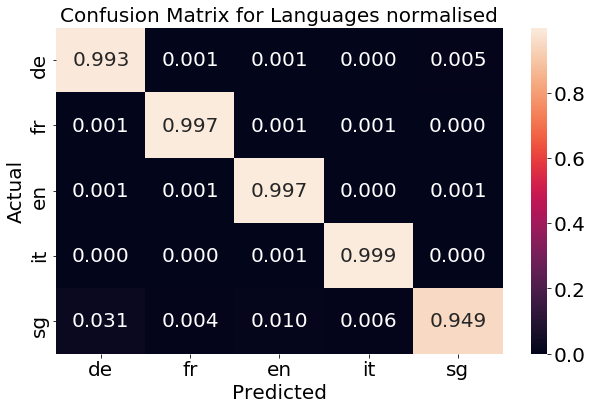

total samples    10706
total errors       312 (2.91%)
---------------------------------
languages detected
    de      206
    fr       26
    en       34
    it       46
    sg    10394


In [28]:
nid = NaiveIdentifier(norm='l2').fit(X_train, y_train)
y_predicted = nid.predict(X_test)
print_results(y_test, y_predicted)
plot_confusion_matrix(y_test, y_predicted, normalised=True)
test_recall_with_sms(nid)

### No IDF

Here, we do the same as above, but without IDF.

We can see that the tendency to boost recall when norm is `None` doesn't hold. More importantly, the difference between the results with and without normalisation is very small... Even unsignificant.

#### No IDF - No normalisation

             precision    recall  f1-score   support

         de     0.9560    0.9945    0.9749      1462
         fr     0.9952    0.9980    0.9966      1468
         en     0.9865    0.9974    0.9919      1538
         it     0.9940    0.9993    0.9966      1482
         sg     0.9941    0.9332    0.9627      1438

avg / total     0.9852    0.9848    0.9847      7388



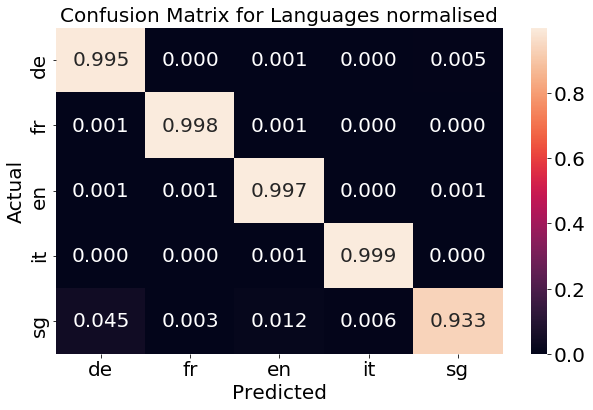

total samples    10706
total errors       417 (3.90%)
---------------------------------
languages detected
    de      300
    fr       33
    en       34
    it       50
    sg    10289


In [32]:
nid = NaiveIdentifier(norm=None, use_idf=False).fit(X_train, y_train)
y_predicted = nid.predict(X_test)
print_results(y_test, y_predicted)
plot_confusion_matrix(y_test, y_predicted, normalised=True)
test_recall_with_sms(nid)

#### No IDF - L2 normalisation

             precision    recall  f1-score   support

         de     0.9560    0.9952    0.9752      1462
         fr     0.9952    0.9980    0.9966      1468
         en     0.9865    0.9974    0.9919      1538
         it     0.9940    0.9987    0.9963      1482
         sg     0.9941    0.9332    0.9627      1438

avg / total     0.9852    0.9848    0.9847      7388



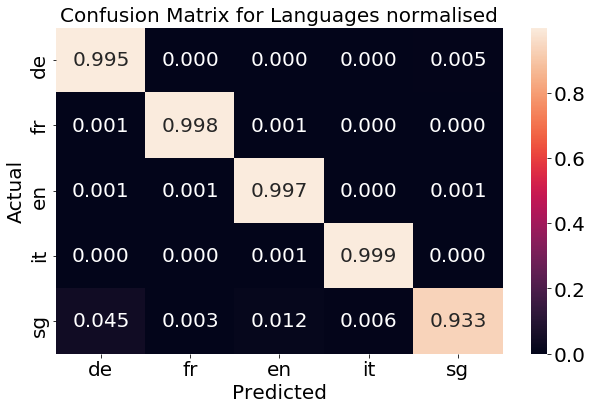

total samples    10706
total errors       417 (3.90%)
---------------------------------
languages detected
    de      300
    fr       33
    en       34
    it       50
    sg    10289


In [33]:
nid = NaiveIdentifier(norm='l2', use_idf=False).fit(X_train, y_train)
y_predicted = nid.predict(X_test)
print_results(y_test, y_predicted)
plot_confusion_matrix(y_test, y_predicted, normalised=True)
test_recall_with_sms(nid)